In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import preprocessing

In [2]:
data = 'Company_Data.csv'
company_data = pd.read_csv(data)

In [3]:
print(company_data.head())

   Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No  


In [4]:
company_data['Sales_Category'] = pd.cut(company_data['Sales'], bins=[float('-inf'), company_data['Sales'].mean(), float('inf')], labels=['Low', 'High'])

In [5]:
company_data.drop('Sales', axis=1, inplace=True)

In [6]:
le = preprocessing.LabelEncoder()
company_data['ShelveLoc'] = le.fit_transform(company_data['ShelveLoc'])
company_data['Urban'] = le.fit_transform(company_data['Urban'])
company_data['US'] = le.fit_transform(company_data['US'])

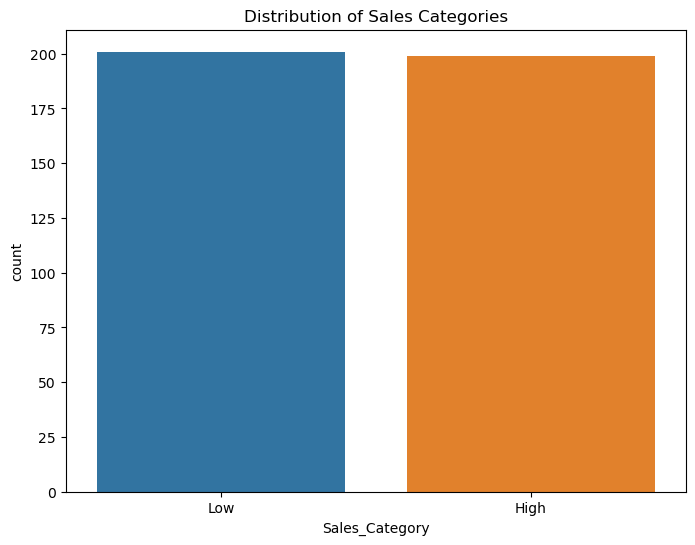

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Sales_Category', data=company_data)
plt.title('Distribution of Sales Categories')
plt.show()

In [8]:
features = company_data.drop('Sales_Category', axis=1)
target = company_data['Sales_Category']

In [9]:
rf_classifier = RandomForestClassifier(random_state=43, criterion='gini')

In [10]:
rf_classifier.fit(features, target)
feature_importances = pd.Series(rf_classifier.feature_importances_, index=features.columns).sort_values(ascending=False)

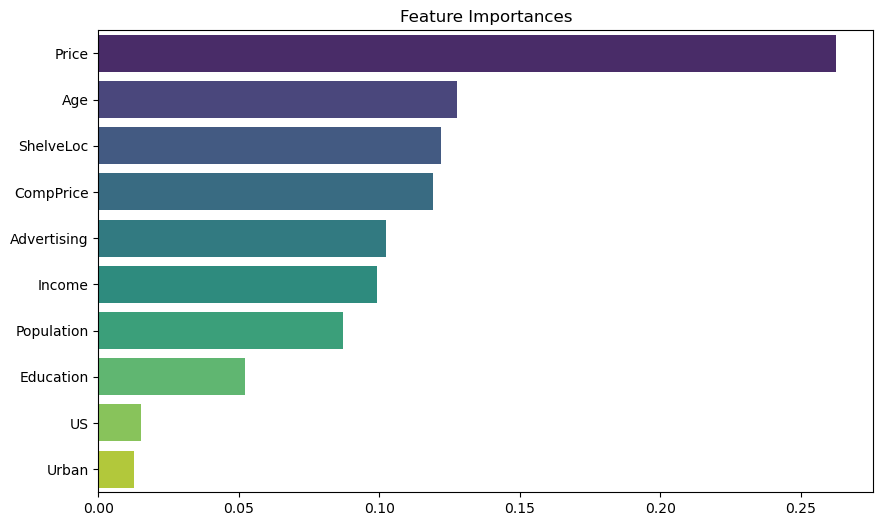

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index, palette="viridis")
plt.title("Feature Importances")
plt.show()


In [12]:
low_importance_columns = feature_importances[feature_importances < 0.05].index
features = features.drop(columns=low_importance_columns)

In [13]:
print("Selected Features:")
print(features.head())

Selected Features:
   CompPrice  Income  Advertising  Population  Price  ShelveLoc  Age  \
0        138      73           11         276    120          0   42   
1        111      48           16         260     83          1   65   
2        113      35           10         269     80          2   59   
3        117     100            4         466     97          2   55   
4        141      64            3         340    128          0   38   

   Education  
0         17  
1         10  
2         12  
3         14  
4         13  


In [14]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [15]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [16]:
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=43),
             param_grid={'max_depth': [None, 5, 10, 15],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=1)

In [17]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [18]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [19]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [20]:
print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.81
Confusion Matrix:
[[35  8]
 [ 7 30]]
Classification Report:
              precision    recall  f1-score   support

        High       0.83      0.81      0.82        43
         Low       0.79      0.81      0.80        37

    accuracy                           0.81        80
   macro avg       0.81      0.81      0.81        80
weighted avg       0.81      0.81      0.81        80



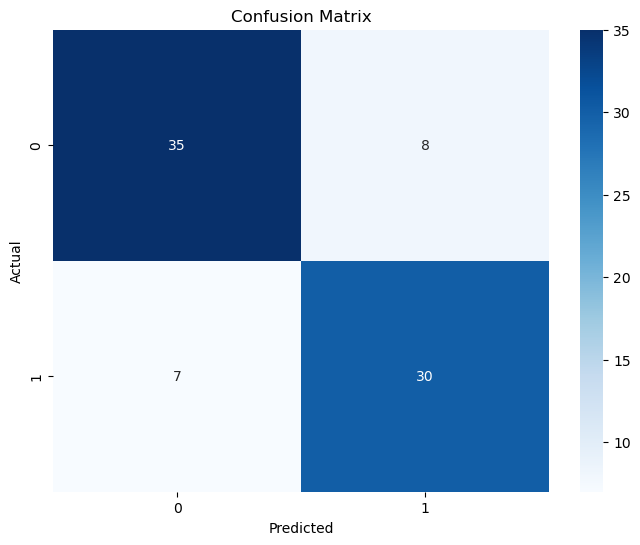

In [21]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [22]:
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

        High       0.83      0.81      0.82        43
         Low       0.79      0.81      0.80        37

    accuracy                           0.81        80
   macro avg       0.81      0.81      0.81        80
weighted avg       0.81      0.81      0.81        80



In [23]:
rf_classifier = RandomForestClassifier(random_state=43, criterion='gini', n_estimators=50, max_depth=None,
                                        min_samples_split=10, min_samples_leaf=2)

In [24]:
ada_classifier = AdaBoostClassifier(base_estimator=rf_classifier, n_estimators=50, random_state=43)
ada_classifier.fit(X_train, y_train)

C:\Anaconda\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=RandomForestClassifier(min_samples_leaf=2,
                                                         min_samples_split=10,
                                                         n_estimators=50,
                                                         random_state=43),
                   random_state=43)

In [25]:
y_pred = ada_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"AdaBoost Accuracy: {accuracy:.2f}")

AdaBoost Accuracy: 0.79


In [26]:
y_pred = ada_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"AdaBoost Accuracy: {accuracy:.2f}")

AdaBoost Accuracy: 0.79


In [27]:
fr = pd.read_csv('Fraud_check.csv')

In [28]:
fr['Taxable.Income'] = np.where(fr['Taxable.Income'] <= 30000, 'Risky', 'Good')

In [29]:
categorical_columns = fr.select_dtypes(include=['object']).columns

In [30]:
fr_encoded = pd.get_dummies(fr, columns=categorical_columns)

In [31]:
print("\nDataset with One-Hot Encoding:")
print(fr_encoded.head())


Dataset with One-Hot Encoding:
   City.Population  Work.Experience  Undergrad_NO  Undergrad_YES  \
0            50047               10             1              0   
1           134075               18             0              1   
2           160205               30             1              0   
3           193264               15             0              1   
4            27533               28             1              0   

   Marital.Status_Divorced  Marital.Status_Married  Marital.Status_Single  \
0                        0                       0                      1   
1                        1                       0                      0   
2                        0                       1                      0   
3                        0                       0                      1   
4                        0                       1                      0   

   Taxable.Income_Good  Taxable.Income_Risky  Urban_NO  Urban_YES  
0                    1      

In [32]:
rf_classifier = RandomForestClassifier(random_state=43, criterion='gini')

In [33]:
print(fr_encoded.columns)

Index(['City.Population', 'Work.Experience', 'Undergrad_NO', 'Undergrad_YES',
       'Marital.Status_Divorced', 'Marital.Status_Married',
       'Marital.Status_Single', 'Taxable.Income_Good', 'Taxable.Income_Risky',
       'Urban_NO', 'Urban_YES'],
      dtype='object')


In [34]:
rf_classifier.fit(fr_encoded.drop(columns=['Undergrad_NO']), fr_encoded['Undergrad_NO'])
feature_importances = pd.Series(rf_classifier.feature_importances_, index=fr_encoded.columns[:-1]).sort_values(ascending=False)

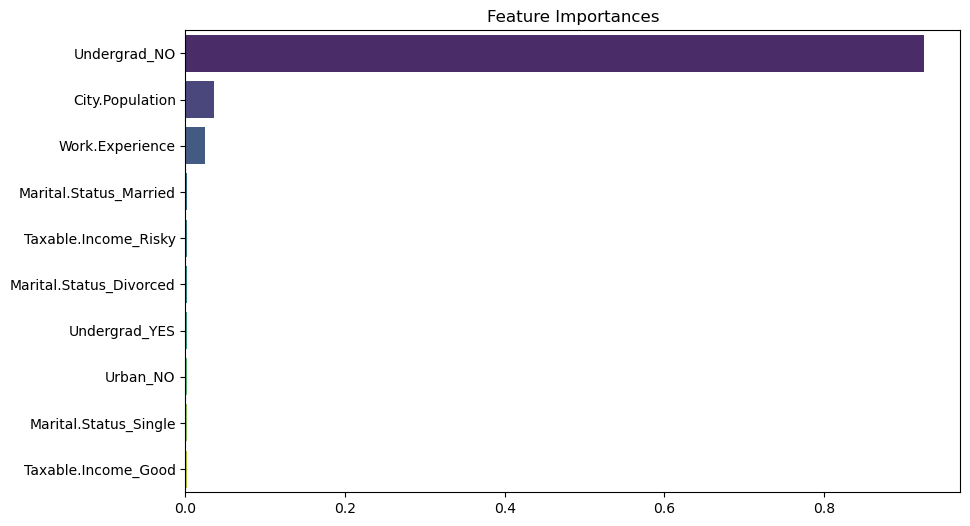

In [35]:
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index, palette="viridis")
plt.title("Feature Importances")
plt.show()

In [36]:
low_importance_columns = feature_importances[feature_importances < 0.05].index
fr_encoded = fr_encoded.drop(columns=low_importance_columns)

In [37]:
print("Selected Features:")
print(fr_encoded.head())

Selected Features:
   Undergrad_NO  Urban_YES
0             1          1
1             0          1
2             1          1
3             0          1
4             1          0


In [38]:
x = fr_encoded.drop(columns=['Undergrad_NO'])
y = fr_encoded['Undergrad_NO']

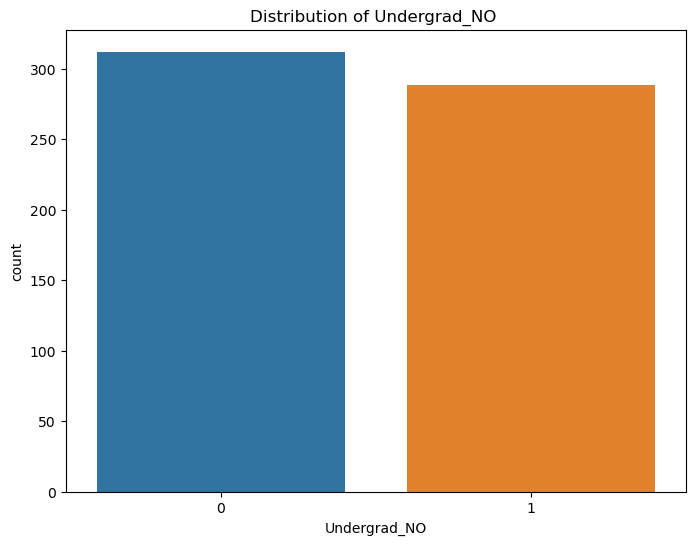

In [39]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title('Distribution of Undergrad_NO ')
plt.show()

In [40]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [41]:
rf_classifier = RandomForestClassifier(random_state=43, criterion='gini', n_estimators=50, max_depth=None,
                                        min_samples_split=10, min_samples_leaf=2)

In [42]:
kfold = 5  # Number of folds for cross-validation

In [43]:
rf_cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=kfold, scoring='accuracy')
print(f"Random Forest Cross-Validation Scores: {rf_cv_scores}")
print(f"Mean Accuracy: {np.mean(rf_cv_scores):.2f}")

Random Forest Cross-Validation Scores: [0.53333333 0.53333333 0.53333333 0.54444444 0.54444444]
Mean Accuracy: 0.54


In [44]:
bagging_classifier = BaggingClassifier(base_estimator=rf_classifier, n_estimators=50, random_state=43)

In [45]:
bagging_cv_scores = cross_val_score(bagging_classifier, X_train, y_train, cv=kfold, scoring='accuracy')
print(f"Bagging Cross-Validation Scores: {bagging_cv_scores}")
print(f"Mean Accuracy: {np.mean(bagging_cv_scores):.2f}")

C:\Anaconda\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging Cross-Validation Scores: [0.53333333 0.53333333 0.53333333 0.54444444 0.54444444]
Mean Accuracy: 0.54


In [46]:
bagging_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_samples': [0.5, 0.7, 1.0],
}

In [47]:
bagging_grid_search = GridSearchCV(bagging_classifier, bagging_param_grid, cv=kfold, scoring='accuracy', verbose=1)
bagging_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Anaconda\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was ren

GridSearchCV(cv=5,
             estimator=BaggingClassifier(base_estimator=RandomForestClassifier(min_samples_leaf=2,
                                                                               min_samples_split=10,
                                                                               n_estimators=50,
                                                                               random_state=43),
                                         n_estimators=50, random_state=43),
             param_grid={'max_samples': [0.5, 0.7, 1.0],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=1)

In [48]:
best_params_bagging = bagging_grid_search.best_params_
print("Best Parameters for Bagging:", best_params_bagging)

Best Parameters for Bagging: {'max_samples': 0.5, 'n_estimators': 50}


In [49]:
best_model_bagging = bagging_grid_search.best_estimator_
y_pred_bagging = best_model_bagging.predict(X_test)

In [50]:
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
print(f"Bagging Accuracy: {accuracy_bagging:.2f}")

Bagging Accuracy: 0.47


In [51]:
ada_classifier = AdaBoostClassifier(base_estimator=rf_classifier, n_estimators=50, random_state=43)

In [52]:
ada_cv_scores = cross_val_score(ada_classifier, X_train, y_train, cv=kfold, scoring='accuracy')
print(f"AdaBoost Cross-Validation Scores: {ada_cv_scores}")
print(f"Mean Accuracy: {np.mean(ada_cv_scores):.2f}")

C:\Anaconda\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoost Cross-Validation Scores: [0.53333333 0.53333333 0.53333333 0.54444444 0.54444444]
Mean Accuracy: 0.54


In [53]:
ada_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.5, 1.0],
}

In [54]:
ada_grid_search = GridSearchCV(ada_classifier, ada_param_grid, cv=kfold, scoring='accuracy', verbose=1)
ada_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Anaconda\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Anaconda\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was ren

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=RandomForestClassifier(min_samples_leaf=2,
                                                                                min_samples_split=10,
                                                                                n_estimators=50,
                                                                                random_state=43),
                                          random_state=43),
             param_grid={'learning_rate': [0.1, 0.5, 1.0],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=1)

In [55]:
best_model_ada = ada_grid_search.best_estimator_
y_pred_ada = best_model_ada.predict(X_test)

In [56]:
accuracy_ada = accuracy_score(y_test, y_pred_ada)
print(f"AdaBoost Accuracy: {accuracy_ada:.2f}")

AdaBoost Accuracy: 0.47
